In [1]:
from data.LSDIR_data import LSDIRDataset

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms
from torchvision.utils import save_image, make_grid

import numpy as np
# from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use("Agg")
from PIL import Image
import imageio

import os, glob, json, random
from typing import List
from utils.NAFNet_arch import NAFNet, NAFNet_zer
from utils.simulator import Simulator
from utils.simulator_zernike import Simulator as Simulator_zer

/home/zhan3275/env/torch2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

# define model hyperparameters
LR = 0.001
IMAGE_SIZE = 512
CHANNELS = 3
BATCH_SIZE = 4
EPOCHS = 50
KLD_WEIGHT = 0.00025
# define the dataset path
DATASET_PATH = "~/data/LSDIR/LSDIR"
train_params = ["~/data/syn_hybrid_2/train/turb_param", "~/lab/data/TurbulenceData/static_new/train_params"]
val_params = ["~/data/syn_hybrid_2/test/turb_param", "~/lab/data/TurbulenceData/static_new/test_params"]

sim_path = "~/turb/recon/semi/utils"

# param_list = []
# for jp in os.listdir(all_jpath):
#     if jp.endswith(".json"):
#         sample = json.load(open(os.path.join(all_jpath, jp), "r"))
#         cn2 = torch.tensor(sample['Cn2']) 
#         sample['Cn2'] = cn2
#         param_list.append(sample)
            
train_transforms = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(IMAGE_SIZE),
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
    ]
)
val_transforms = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
    ]
)

In [3]:
def loss_function(VAELossParams, kld_weight):
    recons, input, _, _, mu, log_var = VAELossParams
    recons_loss = F.mse_loss(recons, input)
    mu = mu.flatten(start_dim=1, end_dim=-1)
    log_var = log_var.flatten(start_dim=1, end_dim=-1)
    kld_loss = -0.5 * torch.mean(1 + log_var - mu**2 - log_var.exp())
    loss = recons_loss + kld_weight * kld_loss
    return {
        "loss": loss,
        "Reconstruction_Loss": recons_loss.detach(),
        "KLD": -kld_loss.detach(),
    }

In [4]:
class ZernikeVAE(nn.Module):
    def __init__(self, train_params: str, val_params: str, sim_path: str, zer_channels: int, img_size: int, init_ks: int, nblocks: int) -> None:
        super(ZernikeVAE, self).__init__()
        enc_blks = [1, 1, 1, nblocks]
        middle_blk_num = 1
        dec_blks = [1, 1, 1, 1]
        self.img_size = img_size
        
        self.param_list_train = []
        for param_path in train_params:
            for jp in os.listdir(param_path):
                if jp.endswith(".json"):
                    sample = json.load(open(os.path.join(param_path, jp), "r"))
                    cn2 = torch.tensor(sample['Cn2'])
                    sample['Cn2'] = cn2
                    self.param_list_train.append(sample)
                    
        self.param_list_val = []
        for param_path in val_params:
            for jp in os.listdir(param_path):
                if jp.endswith(".json"):
                    sample = json.load(open(os.path.join(param_path, jp), "r"))
                    cn2 = torch.tensor(sample['Cn2'])
                    sample['Cn2'] = cn2
                    self.param_list_val.append(sample)
                    
        self.param_list = self.param_list_train
        param_init = self.param_list[0]
        param_init["kernel_size"] = init_ks
        self.simulator = Simulator(sim_path, param_init).cuda()
        for prm in self.simulator.parameters():
            prm.requires_grad = False

        # build the encoder
        self.encoder = NAFNet(img_channel=zer_channels+1, out_channel=2, width=16, middle_blk_num=middle_blk_num,
                      enc_blk_nums=enc_blks, dec_blk_nums=dec_blks)
        
        # build the decoder
        self.decoder = NAFNet_zer(in_channels=1, out_channel=1, width=16, middle_blk_num=middle_blk_num,
                      enc_blk_nums=enc_blks, dec_blk_nums=dec_blks)

    def to_eval(self):
        self.param_list = self.param_list_val
    
    def to_train(self):
        self.param_list = self.param_list_train
        
    # encoding function to map the input to the latent space
    def encode(self, input: Tensor) -> List[Tensor]:
        # pass the input through the encoder
        result = self.encoder(input)
        n_channel = result.shape[1]
        mu = result[:, :n_channel//2, ...]
        log_var = result[:, n_channel//2:, ...]
        return mu, log_var
    
    # decoding function to map the latent space to the reconstructed input
    def decode(self, z: Tensor) -> Tensor:
        result = self.decoder(z)
        return result
    
    # reparameterization trick to sample from the latent space
    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        # compute the standard deviation from the log variance
        std = torch.exp(0.5 * logvar)
        # sample random noise
        eps = torch.randn_like(std)
        # compute the sample from the latent space
        return eps * std + mu
    
    def simulation(self, inp_imgs: Tensor) -> List[Tensor]:
        outputs = []
        zers = []
        all_ks = []
        tilt_imgs = []
        with torch.no_grad():
            for i in range(inp_imgs.shape[0]):
                param = random.choice(self.param_list)
                ks = param["kernel_size"] / 100.0
                param["img_shape"] = (self.img_size, self.img_size)
                self.simulator.change_param(param)
                out, ti, zer = self.simulator(inp_imgs[i:i+1], require_tilt=True)
                ks_embedding = torch.ones((*zer.shape[:-1], 1), device=zer.device).float() * ks
                outputs.append(out.detach())
                zers.append(zer.detach())
                tilt_imgs.append(ti.detach())
                all_ks.append(ks_embedding.detach())
                print(ks)
        return torch.cat(outputs, dim=0), torch.cat(tilt_imgs, dim=0), torch.cat(zers, dim=0), torch.cat(all_ks, dim=0)
    
    # forward pass of the vae
    def forward(self, inp_imgs: Tensor) -> List[Tensor]:
        # encode the input to the latent space
        re_degraded = []
        degraded, tilt_img, zer, ks_map = self.simulation(inp_imgs)
        rec_zer = torch.zeros_like(zer)
        rec_zer[..., :2] = zer[..., :2]
        zer_w_size = torch.cat([zer[..., 2:], ks_map], dim=-1)
        mu, log_var = self.encode(zer_w_size.permute(0,3,1,2))
        log_var = torch.clamp(log_var, min=-10.0, max = 10.0)
        # sample from the latent space
        z = self.reparameterize(mu, log_var)
        # decode the sample, and then degrade the image again
        # rec_zer[..., 2:] = self.decode(z).permute(0,2,3,1) # B, H, W, C
        re_degraded = self.decoder(tilt_img, z)
        return degraded, re_degraded, zer, z, mu, log_var

In [10]:
def validate(model, dataloader, device):
    running_loss = 0
    with torch.no_grad():
        for i, x in enumerate(dataloader):
            x = x.to(device)
            predictions = model(x)
            total_loss = loss_function(predictions, KLD_WEIGHT)
            running_loss += total_loss["loss"].item()
    return running_loss / len(dataloader)

In [9]:
zernike_dataset = LSDIRDataset(DATASET_PATH, transform=train_transforms)
# Define the size of the validation set
val_size = int(len(zernike_dataset) * 0.1)  # 10% for validation
train_size = len(zernike_dataset) - val_size
torch.manual_seed(416)
train_dataset, val_dataset = random_split(zernike_dataset, [train_size, val_size])
# Define the data loaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

In [7]:
loaded = torch.load("model_zoo/VAE_zernike.pth")
init_ks = loaded["vae-zernike"]["simulator.p2s_blur_left.weight"].shape[2]
model = ZernikeVAE(train_params, val_params, sim_path, 33, IMAGE_SIZE, init_ks, 8)
model = model.to(DEVICE)
model.load_state_dict(loaded["vae-zernike"])

/home/zhan3275/env/torch2/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025845206/work/aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<All keys matched successfully>

In [45]:
model.to_train()
with torch.no_grad():
    for i, x in enumerate(val_dataloader):
        x = x.to(DEVICE)
        predictions = model(x)
        degraded, re_degraded, zer, z, mu, log_var = predictions
        if i==0:
            break

0.15
0.19
0.55
0.19


Text(0.5, 1.0, 'input')

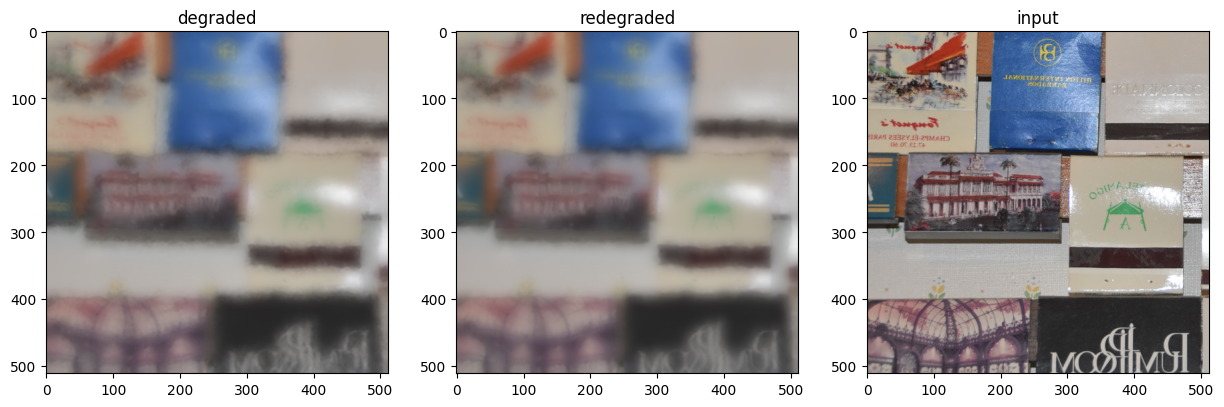

In [53]:
idx = 2
deg = degraded[idx].permute(1,2,0).detach().cpu().numpy()
redeg = re_degraded[idx].permute(1,2,0).detach().cpu().numpy()
inp = x[idx].permute(1,2,0).detach().cpu().numpy()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot on the first subplot
axs[0].imshow(deg)
plt.imsave("degraded.png", deg)
axs[0].set_title('degraded')

# Plot on the second subplot
axs[1].imshow(redeg)
plt.imsave("redegraded.png", redeg)
axs[1].set_title('redegraded')

# Plot on the third subplot
axs[2].imshow(inp)
plt.imsave("input.png", inp)
axs[2].set_title('input')

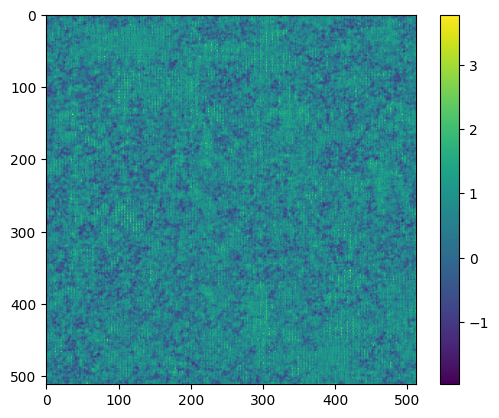

In [47]:
plt.imshow(mu[idx,0,:,:].detach().cpu().numpy())
plt.colorbar()

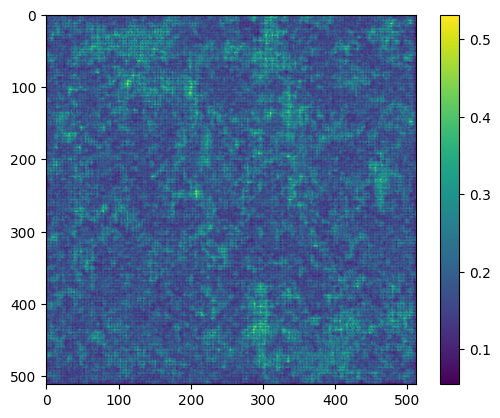

In [48]:
plt.imshow(log_var.exp()[idx,0,:,:].detach().cpu().numpy())
plt.colorbar()

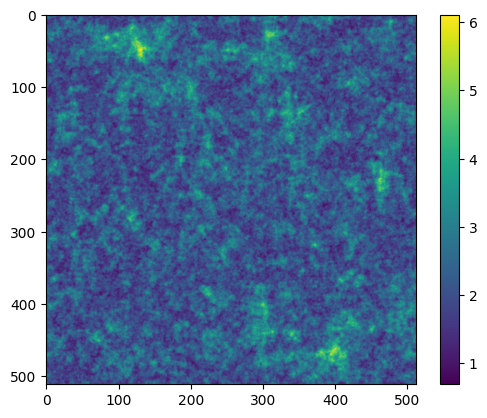

In [50]:
plt.imshow(torch.norm(zer[idx,:,:,2:].detach(), dim=-1, keepdim=True).cpu().numpy())
plt.colorbar()

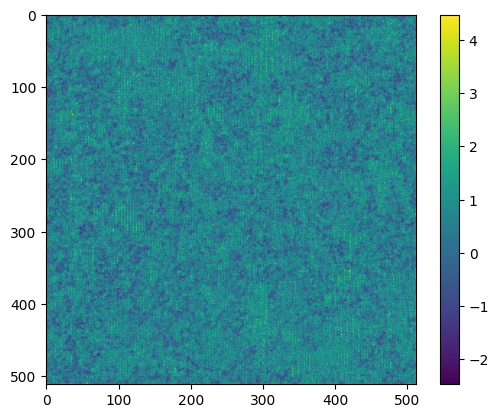

In [49]:
plt.imshow(z[idx,0,:,:].detach().cpu().numpy())
plt.colorbar()

(array([1.40000e+01, 9.00000e+01, 3.62000e+02, 1.11600e+03, 3.22100e+03,
        7.47100e+03, 1.57250e+04, 2.80440e+04, 4.33560e+04, 6.08850e+04,
        7.84300e+04, 9.42540e+04, 1.08330e+05, 1.17626e+05, 1.18703e+05,
        1.10408e+05, 9.34180e+04, 6.99510e+04, 4.61020e+04, 2.68500e+04,
        1.37960e+04, 6.26800e+03, 2.65100e+03, 9.85000e+02, 3.55000e+02,
        1.05000e+02, 3.90000e+01, 1.40000e+01, 3.00000e+00, 4.00000e+00]),
 array([-3.7317152 , -3.45817041, -3.18462563, -2.9110806 , -2.63753581,
        -2.36399102, -2.09044623, -1.81690133, -1.54335654, -1.26981163,
        -0.99626684, -0.72272199, -0.44917718, -0.17563233,  0.09791251,
         0.37145734,  0.64500219,  0.91854703,  1.19209182,  1.46563673,
         1.73918152,  2.01272631,  2.2862711 ,  2.55981612,  2.83336091,
         3.1069057 ,  3.38045049,  3.65399528,  3.9275403 ,  4.20108509,
         4.47462988]),
 <BarContainer object of 30 artists>)

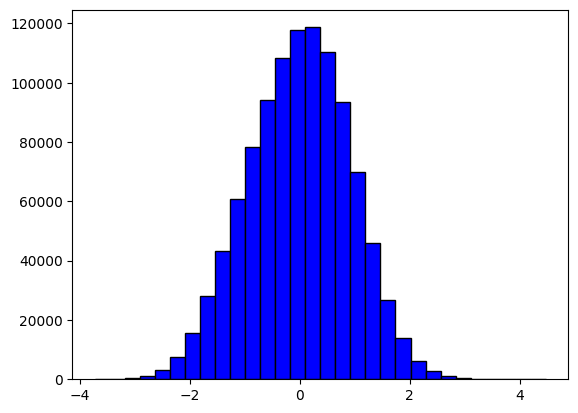

In [54]:
plt.hist(z.flatten().detach().cpu().numpy(), bins=30, color='blue', edgecolor='black')

In [54]:
class TurbSim(object):
    def __init__(self, nb, width, ckpt_path):
        self.blur_model = NAFNet_zer(in_channels=1, out_channel=1, width=width, middle_blk_num=1,
                      enc_blk_nums=[1,1,1,nb], dec_blk_nums=[1,1,1,1]).cuda()
        loaded = torch.load(ckpt_path)
        self.blur_model.load_state_dict(loaded["decoder"])
        for prm in self.blur_model.parameters():
            prm.requires_grad = False
        print("TurbSim loaded!")
    
    def reblur(self, img, LPD):
        B, T, C, H, W = img.shape
        img = img.flatten(0, 1)
        LPD = LPD.flatten(0, 1)
        tilt, mu, logvar = LPD[:,:2,:,:], LPD[:,2:3,:,:], LPD[:,3:4,:,:]
        log_var = torch.clamp(log_var, min=-10.0, max = 10.0)
        tilt_img = flow_warp(img, tilt)
        z = torch.exp(0.5 * logvar) * torch.randn_like(std) + mu
        kld = -0.5 * torch.mean(1 + log_var - mu**2 - log_var.exp())
        turb_img = self.blur_model(tilt.mean(1, keepdim=True), z)
        return tilt_img.view(B, T, C, H, W), turb_img.view(B, T, 1, H, W), kld
    
def get_module_state_dict(model, module_name):
    """Gets the state dict of a specific module within a PyTorch model."""

    state_dict = model.state_dict()
    module_state_dict = {k.replace(module_name, ""): v for k, v in state_dict.items() if k.startswith(module_name)}
    return module_state_dict

torch.save(
    {"decoder": get_module_state_dict(model, "decoder.")},
    "model_zoo/NAF_decoder.pth",
)

ts = TurbSim(8, 16, "model_zoo/NAF_decoder.pth")